# Model 2 report

Model 2 implements a proposed modification to the Lenet5 architecture.

The architecture used in this model is the following:

Input(32x32x3) --> Conv1 --> Actv1 --> Max_Pool1 --> Conv2 --> Actv2 --> Max_Pool2 --> Conv3 --> Actv3--> Dropout --> FC1 --> Actv4 --> Output

Input: Input tensor of shape [None, 32, 32, 3] where the None value is waiting for the batch size.

Conv1: Uses 6 filters of size 5x5

Actv1: Relu activation function is applied

Max_Pool1: Padding of 2 with stride of 2

Conv2: Uses 16 filters of size 5x5

Actv2: Relu activation function is applied

Max_Pool2: Padding of 2 with stride of 2

Conv3: Uses 120 filters of size 5x5

Actv3: Relu activation function is applied

Dropout: Keeps 50% of the data

FC1: Contains 84 units.

Actv4: Relu activation function is applied (the original paper uses a scaled hyperbolic tangent)

Output: Contains 43 units wich are the total number of classes and it uses a softmax function for the output.

Batch normalization is applied to every convolutional layer


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("../src/")

from preprocess_data import *
from lenet5 import *
from utils import *
%matplotlib inline
os.chdir("../")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The dataset contains images of 43 different traffing signs.
The images contained in the provided dataset has a problem with the number of examples per class. Some of the classes contains only two or three images, for that reason, when splitting the data for training and testing, the splitting algorithm randomly selected 80% for training and 20% for testing in each class folder. Due to this, in the testing set some of the classes are not present (i.e. 31, 19, 37, 0). In my opinion it is a better option to split the data in this way because it guarantees that the model can predict all 43 classes (which cannot be done using a standard train_test_split() function).

Afther dividing the training and testing sets, data augmentation was carried out on the training set. This step was not done before splitting the data to prevent overfitting while combining augmented images on the training and testing sets. In this way we can guarantee that the model has never seen the images of the test set nor a transformed form of it.

In [2]:
# Load the data
cwd = os.getcwd()
train_folder = os.path.join(os.getcwd(), "images", "train")
train_images, train_labels = load_dataset(train_folder, img_size=32) #Load the training data
os.chdir(cwd)

  8%|▊         | 422/5010 [00:00<00:01, 4214.52it/s]

#============ Loading Data ============#


100%|██████████| 5010/5010 [00:00<00:00, 5199.60it/s]


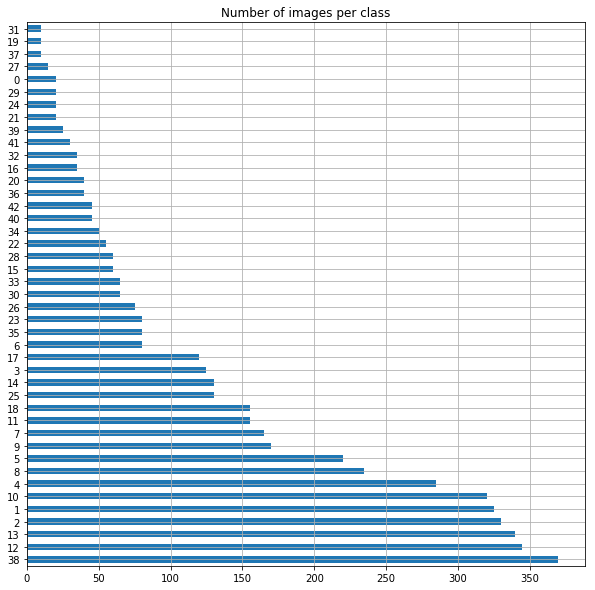

In [3]:
# Plot the distribution of the triaining data
matplotlib.rcParams['figure.figsize'] = [10, 10]
df = pd.Series(train_labels)
df.value_counts().plot('barh', grid=True, title="Number of images per class")

We can see that the classes are highly unbalanced and when the model evaluates the test data, it will missclassify the classes with fewer training images.
The data augmentation process creates 4 new images from every single image. For example if a class has originally 2 images, after augmentation it will have 10 images (2x4 + 2).


The model process used  mean cross entropy as the loss for the classification problem.

The optimizer used for training was Adam (adaptive moment estimation).

The learning rate used was: 0.001.

The model was trained for 10 epochs.

The batch size used was 32. Each minibath was created using the tf.data API.

Xavier initialization was implemented for initialiazing the convolutional layers.

# Train accuracy

Data during training is randomized. The accuracy obtained by the model on the training set is 6.5%.

In [4]:
# Calculate the accuracy on the training data
train_preds = evaluate_lenet5(d=train_folder, model="model2", n_classes= 43, mode="train")
train_preds = np.array(train_preds)

 10%|█         | 522/5010 [00:00<00:00, 5210.82it/s]

#============ Loading Data ============#


100%|██████████| 5010/5010 [00:00<00:00, 5507.61it/s]


Number of training examples = 5010
X_train shape: (5010, 32, 32, 3)
Y_train shape: (5010, 43)
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from /home/camiloiral/Workspace/kiwi_challenge/German_Traffic_Signs_Detector/models/model2/saved/lenet5_improved
#============ train accuracy: 0.06586826592683792 ============#


In [5]:
# Compare predictions with real labels
true_train_preds = np.equal(train_labels, train_preds)
df_preds = pd.DataFrame({"true_label":train_labels, "prediction":train_preds, "is_equal":true_train_preds})

To see more clear what is happening, we are going to compare the correct number of predictions per class. But first we look at exactly how many training examples are per class

In [6]:
df1 = df_preds.groupby("true_label")["true_label"].agg(["count"])
print(df1)

            count
true_label       
0              20
1             325
2             330
3             125
4             285
5             220
6              80
7             165
8             235
9             170
10            320
11            155
12            345
13            340
14            130
15             60
16             35
17            120
18            155
19             10
20             40
21             20
22             55
23             80
24             20
25            130
26             75
27             15
28             60
29             20
30             65
31             10
32             35
33             65
34             50
35             80
36             40
37             10
38            370
39             25
40             45
41             30
42             45


Then compare the how many predictions were correct and incorrect per class

In [7]:
df2 = df_preds.groupby(["true_label","is_equal"]).agg(["count"])
print(df2)

                    prediction
                         count
true_label is_equal           
0          False            20
1          False           325
2          True            330
3          False           125
4          False           285
5          False           220
6          False            80
7          False           165
8          False           235
9          False           170
10         False           320
11         False           155
12         False           345
13         False           340
14         False           130
15         False            60
16         False            35
17         False           120
18         False           155
19         False            10
20         False            40
21         False            20
22         False            55
23         False            80
24         False            20
25         False           130
26         False            75
27         False            15
28         False            60
29      

Plotting the difference shown in the data above we get:

In [8]:
def info_predictions(y_true, y_pred):
    data = {}
    for i in range(43):
        count_equal = 0
        count_diff = 0
        for j in range(len(y_true)):
            if y_true[j] == y_pred[j] == i:
                count_equal += 1
            elif y_true[j] == i != y_pred[j]:
                count_diff += 1
        data[i] = [count_equal, count_diff]
    
    df = pd.DataFrame(data).transpose()
    df.columns = ["equal", "not_equal"]
    return df

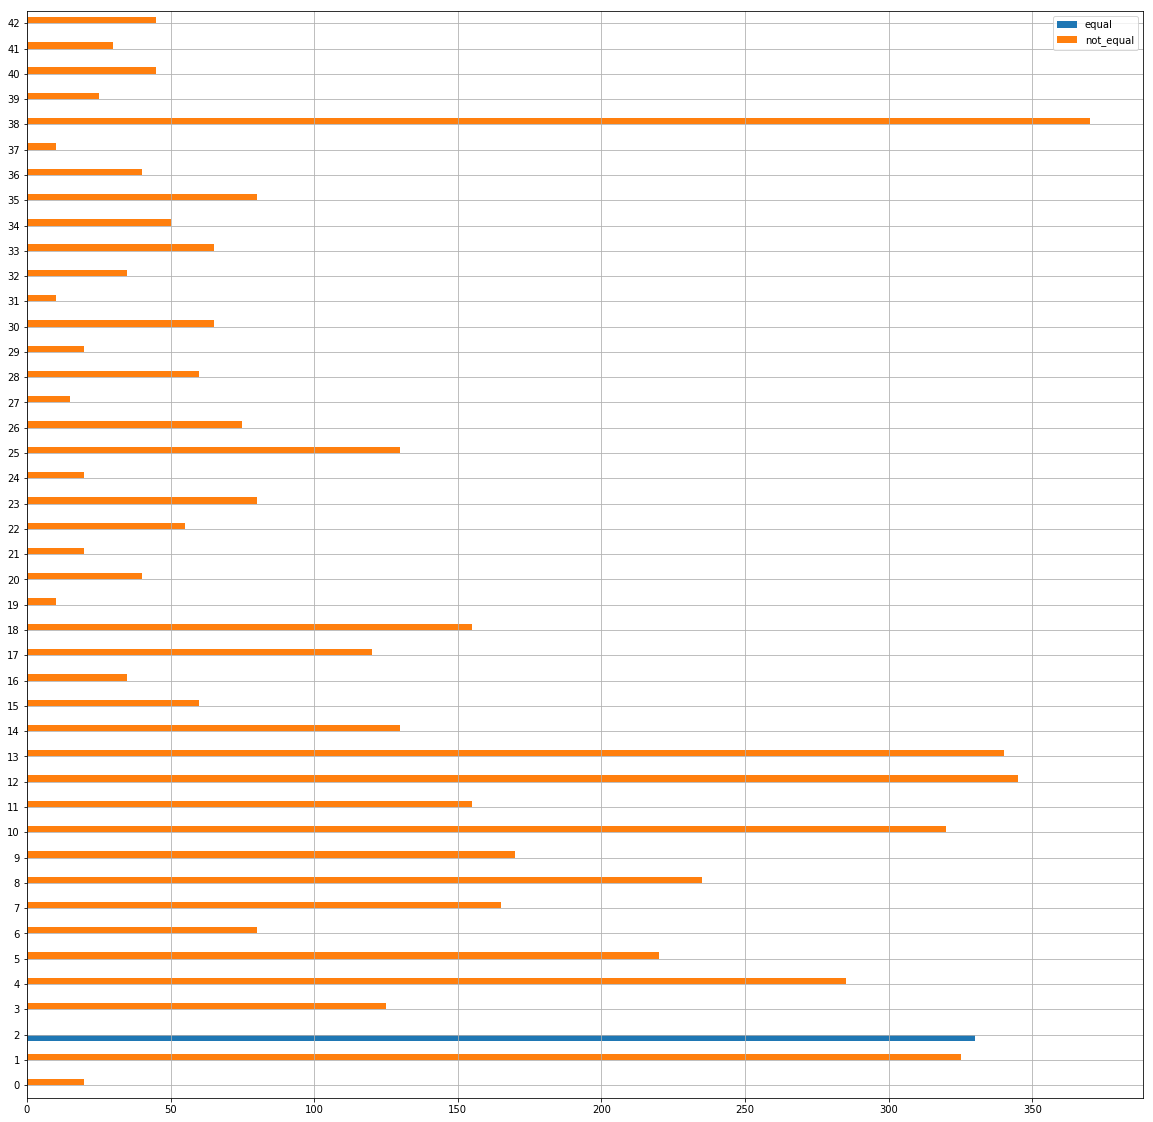

In [9]:
matplotlib.rcParams['figure.figsize'] = [20, 20]
df = info_predictions(train_labels, train_preds)
df.plot(kind = "barh", grid=True)

We can clearly see that the model is not working at all and it is classifing all the training data as class 2.

# Test accuracy

The accuracy obtained by the model on the testing set is 7.1%.

In [10]:
test_folder = os.path.join(os.getcwd(), "images", "test")
test_images, test_labels = load_dataset(test_folder, img_size=32) #Load the testing data
os.chdir(cwd)

100%|██████████| 211/211 [00:00<00:00, 3885.46it/s]

#============ Loading Data ============#


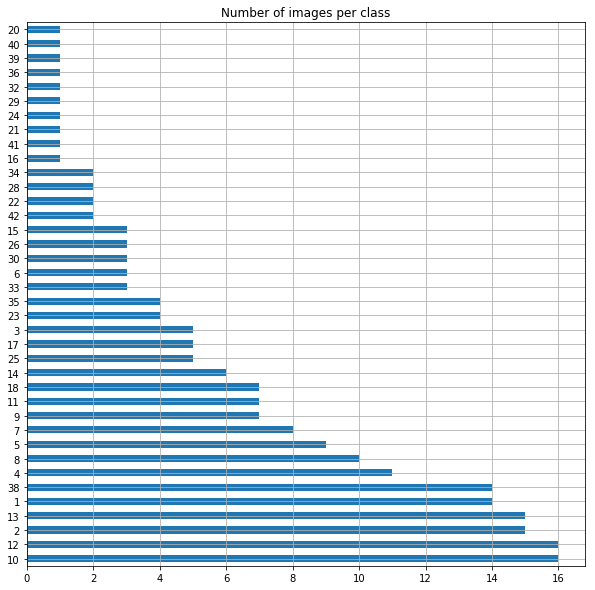

In [11]:
matplotlib.rcParams['figure.figsize'] = [10, 10]
df = pd.Series(test_labels)
df.value_counts().plot('barh', grid=True, title="Number of images per class")

In [12]:
tf.reset_default_graph()
test_preds = evaluate_lenet5(d=test_folder, model="model2", n_classes= 43, mode="test")
test_preds = np.array(test_preds)

100%|██████████| 211/211 [00:00<00:00, 4206.78it/s]

#============ Loading Data ============#
Number of testing examples = 211
X_test shape: (211, 32, 32, 3)
Y_test shape: (211, 43)


INFO:tensorflow:Restoring parameters from /home/camiloiral/Workspace/kiwi_challenge/German_Traffic_Signs_Detector/models/model2/saved/lenet5_improved
#============ test accuracy: 0.07109005004167557 ============#


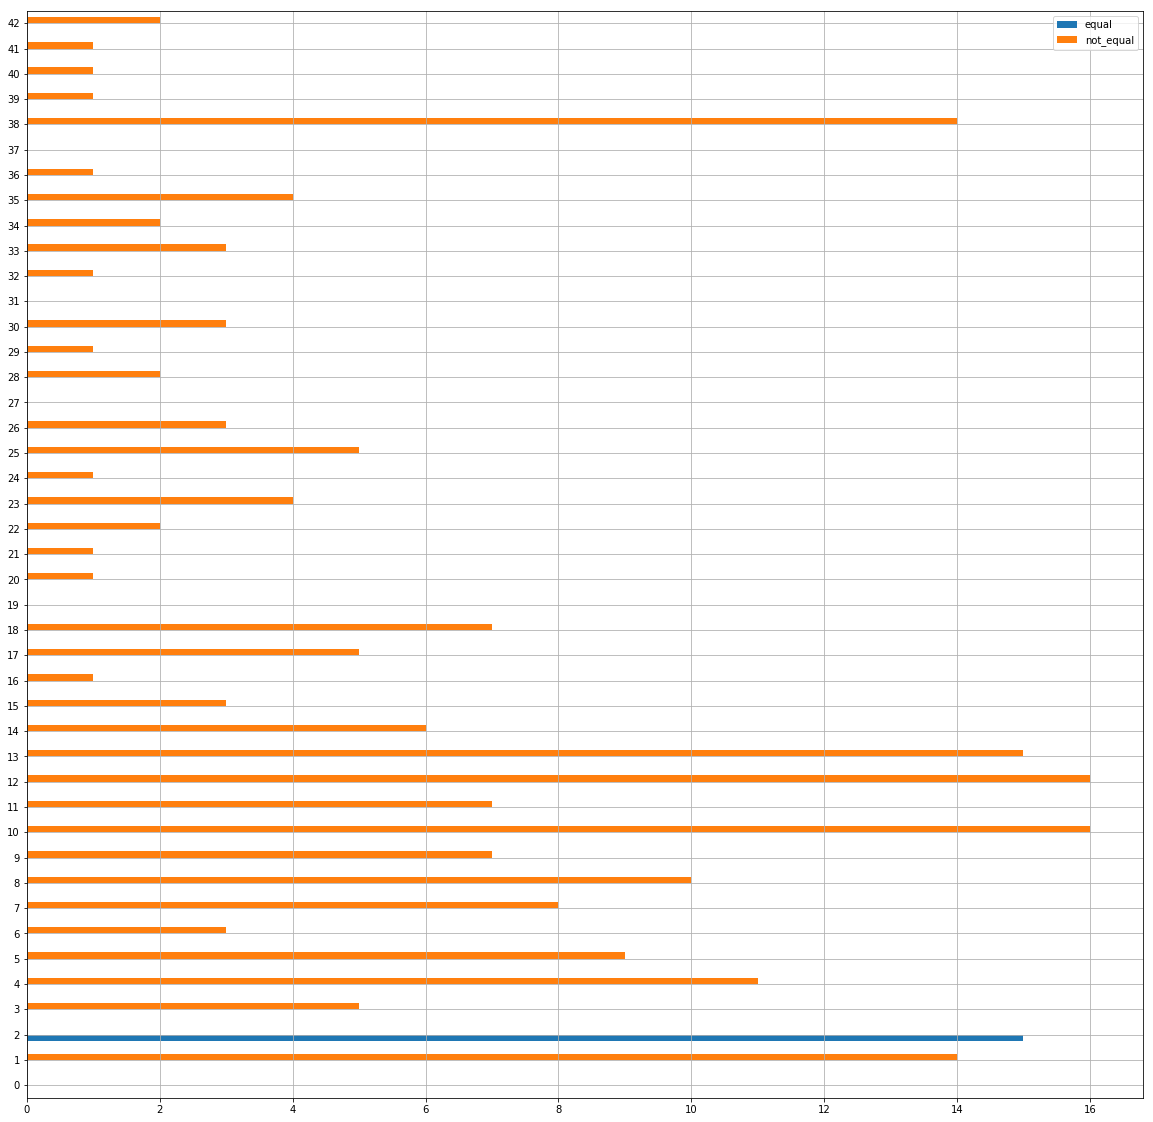

In [13]:
matplotlib.rcParams['figure.figsize'] = [20, 20]
df = info_predictions(test_labels, test_preds)
df.plot(kind = "barh", grid=True)

As in training, the model is predicting everything as class 2. The model is not working

# Conclusions:

Testing data is guaranteed that has never been seen by the model. 

The model is not working properly. It is clear that it has to be reviewed to find a possible bug or to change some values in the architecture. 